In [1]:
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Dict


pd.options.display.float_format = "{:.3f}".format
sns.set(style='darkgrid', context='talk', palette='rainbow')


from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, 
                              RandomForestClassifier)
import shap
shap.initjs()

%matplotlib inline

/Users/adolfo/Documents/ta-data-analysis-challenge/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Parte 0 - Introduccion al Desafío Data Analyst - Total Abogados



## Dataset

El dataset





## Preguntas de Negocio

1. What are the most common types of credit card transactions in the dataset?
2. What are the key features that differentiate fraudulent transactions from normal transactions?
3. Can we build a model that accurately predicts fraudulent transactions in real-time?
4. What is the average transaction amount in the dataset and how does it vary by country?
5. How does the number of transactions per day change over time?
6. What is the average time between a transaction being made and it being recognized as fraud?
7. Can we identify any specific geographic locations or merchant categories that are more susceptible to credit card fraud?
8. What are the most common times of day when credit card fraud occurs?
9. Are there any seasonal trends in the frequency of credit card fraud?
10. Can we determine the most effective strategy for preventing credit card fraud using the information in the dataset?





## Outline de la Implementación

El dataset

## Limitaciones


Limitaciones de la implementacion:
1. El dataset esta compuesto por 50 IDs distintas y 24 columnas. Un tamano de muestra tan pequeño dificulta la obtencion de conclusiones. 


# Parte 1 - Carga y Revision de los Dataset


En esta etapa, cargamos los datos desde cada uno de los datasets y analizamos su contenido.  Usamos una metodologia de **ETL** para obtencion, transformacion y cargade los datos.

Los pasos a seguir seran:
1. Cargar los datos desde cada uno de los datasets. En este paso, especificamos typos de datos y lista de valores faltantes customizados.
2. Analizamos los data types obtenidos para cada columna
3. Investigamos si hay datos faltantes
4. Investigamos si hay datos duplicados

## UCI_Credit_Card_BillATM.csv

In [2]:
def extract_bill_atm() -> pd.DataFrame:
    """Extrae la data a partir de un fichero de UCI_Credit_Card_BillATM.csv"""
    filename = "data/1 raw/UCI_Credit_Card_BillATM.csv"
    df = pd.read_csv(filename, index_col=0 ,na_values={"LIMIT_BAL": ["-"]}, dtype={"LIMIT_BAL": "float64"})

    df.set_index("ID", inplace=True)
    df.sort_index(inplace=True)

    return df



df_bill_extract = extract_bill_atm()
df_bill_extract.head()



,LIMIT_BAL,SEX,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
ID,,,,,,,,
1,20000.000,female,3913.000,3102.000,689.000,0.000,0.000,0.000
1,20000.000,female,3913.000,3102.000,689.000,0.000,0.000,0.000
2,120000.000,NaN,2682.000,1725.000,2682.000,3272.000,3455.000,3261.000
3,90000.000,female,29239.000,14027.000,13559.000,14331.000,14948.000,15549.000
4,50000.000,female,46990.000,48233.000,49291.000,28314.000,28959.000,29547.000


In [3]:
df_bill_extract.dtypes

LIMIT_BAL    float64
SEX           object
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
BILL_AMT4    float64
BILL_AMT5    float64
BILL_AMT6    float64
dtype: object

In [4]:
df_bill_extract.describe()

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,46.000,52.000,52.000,52.000,52.000,52.000,52.000
mean,160652.174,40476.115,39074.577,38418.827,42871.423,32894.154,34781.923
std,157824.124,69774.513,73656.656,73852.238,113904.603,74466.870,75981.531
min,10000.000,-109.000,-425.000,-527.000,-923.000,-28335.000,-1884.000
25%,50000.000,4325.500,3163.500,1397.250,1822.500,505.750,504.250
50%,100000.000,15191.500,16311.000,15467.000,14835.000,15811.500,12770.500
75%,225000.000,47147.500,41968.750,38272.250,28428.250,29102.000,29671.750
max,630000.000,367965.000,412023.000,445007.000,628699.000,483003.000,473944.000


In [5]:
# Busqueda de valores faltantes
df_bill_extract.isna().sum()

LIMIT_BAL    6
SEX          7
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
dtype: int64

In [6]:
df_bill_extract[df_bill_extract.duplicated()]

,LIMIT_BAL,SEX,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
ID,,,,,,,,
1,20000.000,female,3913.000,3102.000,689.000,0.000,0.000,0.000
6,50000.000,male,64400.000,57069.000,57608.000,19394.000,19619.000,20024.000


In [7]:
# Revisamos aquellas IDs que tienen valores faltantes
df_bill_extract[df_bill_extract.isna().any(axis=1)]

,LIMIT_BAL,SEX,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
ID,,,,,,,,
2,120000.000,NaN,2682.000,1725.000,2682.000,3272.000,3455.000,3261.000
9,140000.000,NaN,11285.000,14096.000,12108.000,12211.000,11793.000,3719.000
12,260000.000,NaN,12261.000,21670.000,9966.000,8517.000,22287.000,13668.000
14,NaN,male,65802.000,67369.000,65701.000,66782.000,36137.000,36894.000
19,NaN,female,0.000,0.000,0.000,0.000,0.000,0.000
22,120000.000,NaN,316.000,316.000,316.000,0.000,632.000,316.000
23,NaN,female,41087.000,42445.000,45020.000,44006.000,46905.000,46012.000
25,NaN,male,4744.000,7070.000,0.000,5398.000,6360.000,8292.000
32,50000.000,NaN,30518.000,29618.000,22102.000,22734.000,23217.000,23680.000



### Hallazgos
AL extraer los datos usando el metodo `extract_bill_atm`, notamos lo siguiente:

1. Archivo contiene campos:  `ID`, `LIMIT_BALL`, `SEX`, `BILL_ATM1` hasta `BILL_ATM6`.
2. Campos `LIMIT_BALL` y `SEX` tienen valores faltantes.
3. `SEX` contiene valores categoricos `male` y `female`. En este momento, se encuentran en modo "string" y no en modo "category" o "one-hot encoding".
4. Hay ID's duplicadas.
5. Los campos `BILL_ATM1` y `BILL_ATM6` son valores numericos.






## UCI_Credit_Card_PAY.csv

In [8]:
def extract_pay() -> pd.DataFrame:
    filename = "data/1 raw/UCI_Credit_Card_Pay.csv"
    df = pd.read_csv(filename, index_col=0, na_values={"LIMIT_BAL": ["-"], "AGE": ["No info"]}, dtype={"LIMIT_BAL":np.float64})

    df.set_index("ID", inplace=True)
    df.sort_index(inplace=True)
    return df


In [9]:
df_pay_extract = extract_pay()
df_pay_extract.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
ID,,,,,,,,
1,20000.000,NaN,2,2,-1,-1,-2,-2
1,20000.000,NaN,2,2,-1,-1,-2,-2
2,120000.000,26 years,-1,2,0,0,0,2
3,90000.000,34 years,0,0,0,0,0,0
4,50000.000,37 years,0,0,0,0,0,0


In [10]:
df_pay_extract.dtypes

LIMIT_BAL    float64
AGE           object
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
dtype: object

In [11]:
df_pay_extract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 1 to 50
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  45 non-null     float64
 1   AGE        44 non-null     object 
 2   PAY_0      52 non-null     int64  
 3   PAY_2      52 non-null     int64  
 4   PAY_3      52 non-null     int64  
 5   PAY_4      52 non-null     int64  
 6   PAY_5      52 non-null     int64  
 7   PAY_6      52 non-null     int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 3.7+ KB


In [12]:
# Busqueda de valores faltantes
df_pay_extract.isna().sum()

LIMIT_BAL    7
AGE          8
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
dtype: int64

In [13]:
# Revisamos aquellas IDs que tienen valores faltantes
df_pay_extract[df_pay_extract.isna().any(axis=1)]

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
ID,,,,,,,,
1,20000.000,NaN,2,2,-1,-1,-2,-2
1,20000.000,NaN,2,2,-1,-1,-2,-2
6,50000.000,NaN,0,0,0,0,0,0
11,NaN,34 years,0,0,2,0,0,-1
16,50000.000,NaN,1,2,0,0,0,0
21,130000.000,NaN,0,0,0,0,0,-1
26,NaN,23 years,0,0,0,0,0,0
26,NaN,23 years,0,0,0,0,0,0
31,NaN,27 years,-1,-1,-1,-1,-1,-1


In [14]:
df_pay_extract.duplicated().sum()

2

In [15]:
df_pay_extract[df_pay_extract.duplicated()]

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
ID,,,,,,,,
1,20000.000,NaN,2,2,-1,-1,-2,-2
26,NaN,23 years,0,0,0,0,0,0


### Hallazgos

AL extraer los datos usando el metodo `extract_card_pay`, notamos lo siguiente:

1. Archivo contiene campos:  `ID`, `LIMIT_BALL`, `AGE`, `PAY_0` hasta `PAY_6`, saltandose `PAY_1`.
2. Campos `LIMIT_BALL` y `AGE` tienen valores faltantes. Estos valores faltantes no son los mismos que en la seccion 1.a, lo cual nos indica que podemos recuperar informacion perdida.
3. `AGE` contiene el string 'years' que debe ser retirado para podewr procesar las edades. Adicionalmente, hay una amplia variacion en las edades, por lo cuaal es conveniente agrupar las edades en rangos etarios.
4. Hay ID's duplicadas.
5. Los campos `PAY_0` hasta `PAY_6` son valores categoricos.


## UCI_Credit_Card_PayATM.csv

In [16]:
def extract_pay_atm() -> pd.DataFrame:
    filename ="data/1 raw/UCI_Credit_Card_PayATM.csv"
    df = pd.read_csv(filename, index_col=0,  na_values={"LIMIT_BAL": ["-"], "EDUCATION": ["Null"]})


    df.set_index("ID", inplace=True)
    df.sort_index(inplace=True)
    return df

In [17]:
df_pay_atm_extract = extract_pay_atm()
df_pay_atm_extract.head()

,LIMIT_BAL,EDUCATION,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,
1,20000.000,2.000,0.000,689.000,0.000,0.000,0.000,0.000
1,20000.000,2.000,0.000,689.000,0.000,0.000,0.000,0.000
2,120000.000,2.000,0.000,1000.000,1000.000,1000.000,0.000,2000.000
3,90000.000,NaN,1518.000,1500.000,1000.000,1000.000,1000.000,5000.000
4,NaN,2.000,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000


In [18]:
df_pay_atm_extract.dtypes

LIMIT_BAL    float64
EDUCATION    float64
PAY_AMT1     float64
PAY_AMT2     float64
PAY_AMT3     float64
PAY_AMT4     float64
PAY_AMT5     float64
PAY_AMT6     float64
dtype: object

In [19]:
df_pay_atm_extract.describe()

,LIMIT_BAL,EDUCATION,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,45.000,45.000,52.000,52.000,52.000,52.000,52.000,52.000
mean,163555.556,1.756,4814.558,4920.519,5199.731,8909.442,7749.885,4025.827
std,153994.621,0.883,8879.390,8952.014,12122.670,27900.882,28067.827,10730.717
min,10000.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,50000.000,1.000,945.000,376.000,37.500,325.500,192.750,0.000
50%,100000.000,2.000,2003.500,1500.000,1000.500,1100.000,1031.000,898.500
75%,250000.000,2.000,3350.500,3811.500,4381.000,4600.000,3000.000,2125.000
max,630000.000,5.000,55000.000,40000.000,75940.000,188840.000,195599.000,51582.000


In [20]:
# Busqueda de valores faltantes
df_pay_atm_extract.isna().sum()

LIMIT_BAL    7
EDUCATION    7
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dtype: int64

In [21]:
# Revisamos aquellas IDs que tienen valores faltantes
df_pay_atm_extract[df_pay_atm_extract.isna().any(axis=1)]

,LIMIT_BAL,EDUCATION,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,
3,90000.000,NaN,1518.000,1500.000,1000.000,1000.000,1000.000,5000.000
4,NaN,2.000,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000
4,NaN,2.000,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000
7,NaN,1.000,55000.000,40000.000,38000.000,20239.000,13750.000,13770.000
10,20000.000,NaN,0.000,0.000,0.000,13007.000,1122.000,0.000
13,630000.000,NaN,1000.000,6500.000,6500.000,6500.000,2870.000,0.000
24,450000.000,NaN,19428.000,1473.000,560.000,0.000,0.000,1128.000
27,NaN,1.000,0.000,1000.000,0.000,500.000,0.000,1000.000
28,NaN,3.000,1300.000,1300.000,1000.000,1500.000,1000.000,1012.000


In [22]:
df_pay_atm_extract.duplicated().sum()

2

In [23]:
df_pay_atm_extract[df_pay_atm_extract.duplicated()]

,LIMIT_BAL,EDUCATION,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,
1,20000.000,2.000,0.000,689.000,0.000,0.000,0.000,0.000
4,NaN,2.000,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000


### Hallazgos

AL extraer los datos usando el metodo `extract_card_pay`, notamos lo siguiente:

1. Archivo contiene campos:  `ID`, `LIMIT_BALL`, `AGE`, `PAY_0` hasta `PAY_6`, saltandose `PAY_1`.
2. Campos `LIMIT_BALL` y `AGE` tienen valores faltantes. Estos valores faltantes no son los mismos que en la seccion 1.a, lo cual nos indica que podemos recuperar informacion perdida.
3. `AGE` contiene el string 'years' que debe ser retirado para podewr procesar las edades. Adicionalmente, hay una amplia variacion en las edades, por lo cuaal es conveniente agrupar las edades en rangos etarios.
4. Hay ID's duplicadas.
5. Los campos `PAY_0` hasta `PAY_6` son valores categoricos.


## UCI_Credit_Card_PayNextMonth.csv

In [24]:
def extract_pay_next() -> pd.DataFrame:
    df = pd.read_csv("data/1 raw/UCI_Credit_Card_PayNextMonth.csv", index_col=0, na_values={"SEX": ["Nan"]})

    df.set_index("ID", inplace=True)
    df.sort_index(inplace=True)
    return df

In [25]:
df_pay_next_extract = extract_pay_next()
df_pay_next_extract.head()

,SEX,EDUCATION,MARRIAGE,AGE,default.payment.next.month
ID,,,,,
1,2.000,2.000,1,24.000,1
2,2.000,2.000,2,26.000,1
3,2.000,2.000,2,34.000,0
4,2.000,NaN,1,37.000,0
5,1.000,2.000,1,57.000,0


In [26]:
df_pay_next_extract.dtypes

SEX                           float64
EDUCATION                     float64
MARRIAGE                        int64
AGE                           float64
default.payment.next.month      int64
dtype: object

In [27]:
df_pay_next_extract.describe()

,SEX,EDUCATION,MARRIAGE,AGE,default.payment.next.month
count,44.000,44.000,50.000,44.000,50.000
mean,1.545,1.659,1.760,33.273,0.260
std,0.504,0.745,0.476,9.520,0.443
min,1.000,1.000,1.000,22.000,0.000
25%,1.000,1.000,1.250,26.000,0.000
50%,2.000,1.500,2.000,30.000,0.000
75%,2.000,2.000,2.000,39.000,0.750
max,2.000,3.000,3.000,58.000,1.000


In [28]:
# Busqueda de valores faltantes
df_pay_next_extract.isna().sum()

SEX                           6
EDUCATION                     6
MARRIAGE                      0
AGE                           6
default.payment.next.month    0
dtype: int64

In [29]:
# Revisamos aquellas IDs que tienen valores faltantes
df_pay_next_extract[df_pay_next_extract.isna().any(axis=1)]

,SEX,EDUCATION,MARRIAGE,AGE,default.payment.next.month
ID,,,,,
4,2.000,NaN,1,37.000,0
7,1.000,NaN,2,29.000,0
11,2.000,3.000,2,NaN,0
14,NaN,2.000,2,30.000,1
19,NaN,1.000,1,49.000,0
23,NaN,2.000,2,26.000,1
25,NaN,1.000,2,23.000,0
26,1.000,3.000,2,NaN,0
27,1.000,NaN,2,27.000,1


In [30]:
df_pay_next_extract.duplicated().sum()

1

In [31]:
df_pay_next_extract[df_pay_next_extract.duplicated()]

,SEX,EDUCATION,MARRIAGE,AGE,default.payment.next.month
ID,,,,,
44,2.000,2.000,1,NaN,0


### Hallazgos

AL extraer los datos usando el metodo `extract_card_pay`, notamos lo siguiente:

1. Archivo contiene campos:  `ID`, `LIMIT_BALL`, `AGE`, `PAY_0` hasta `PAY_6`, saltandose `PAY_1`.
2. Campos `LIMIT_BALL` y `AGE` tienen valores faltantes. Estos valores faltantes no son los mismos que en la seccion 1.a, lo cual nos indica que podemos recuperar informacion perdida.
3. `AGE` contiene el string 'years' que debe ser retirado para podewr procesar las edades. Adicionalmente, hay una amplia variacion en las edades, por lo cuaal es conveniente agrupar las edades en rangos etarios.
4. Hay ID's duplicadas.
5. Los campos `PAY_0` hasta `PAY_6` son valores categoricos.


# Parte 3 y 4 - Transformacion

En el enunciado se nos pide seguir las siguientes transformaciones: 
1. Unir los datasets (Paso 3)
2. Limpia, depurar e imputar la base de datos.

Debido a que hay:
1. Columnas repetidas en las bases datos
2. Datos repetidos en las bases datos
3. Datos faltantes en las bases datos en columnas repetidas, en donde el dato faltante nos el mismo en todos datasets

realizar un merge seria poco conveniente ya que nos dejaria con multiples versiones de la mismas columnas.

En su lugar, nos  resulta conveniente aplicar las siguientes transformaciones:
1. Limpieza y depuracion de la base de datos
2. Union de los datasets
3. Imputacion




In [32]:
def transform_clean_bill_atm(df: pd.DataFrame) -> pd.DataFrame:
    df["SEX"] = df["SEX"].astype("category")

    df.drop_duplicates(inplace=True) # ID 1 and 26 is duplicated
    return df

def transform_clean_card_pay(df: pd.DataFrame) -> pd.DataFrame:
    
    df["AGE"] = df["AGE"].astype(str).str.extract('(\d+)')
    df["AGE"] = df["AGE"].astype("Int64", errors="ignore")

    df.drop_duplicates(inplace=True)
    return df



def transform_clean_card_pay_atm(df: pd.DataFrame) -> pd.DataFrame:
    df["EDUCATION"] = df["EDUCATION"].astype("category", errors="ignore")
    df.drop_duplicates(inplace=True)
    return df


def transform_clean_card_pay_next_month(df: pd.DataFrame) -> pd.DataFrame:

    df.loc[df["SEX"] == 1.0, "SEX"] = "male"
    df.loc[df["SEX"] == 2.0, "SEX"] = "female"
    df["SEX"] = df["SEX"].astype("category")
    df["MARRIAGE"] = df["MARRIAGE"].astype("category")
    df["AGE"] = df["AGE"].astype("Int64", errors="ignore")
    df["EDUCATION"] = df["EDUCATION"].astype("category", errors="ignore")
    

    df.drop_duplicates(inplace=True)
    return df




In [33]:
df_bill_clean = transform_clean_bill_atm(df_bill_extract)
df_bill_clean.head()

,LIMIT_BAL,SEX,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
ID,,,,,,,,
1,20000.000,female,3913.000,3102.000,689.000,0.000,0.000,0.000
2,120000.000,NaN,2682.000,1725.000,2682.000,3272.000,3455.000,3261.000
3,90000.000,female,29239.000,14027.000,13559.000,14331.000,14948.000,15549.000
4,50000.000,female,46990.000,48233.000,49291.000,28314.000,28959.000,29547.000
5,50000.000,male,8617.000,5670.000,35835.000,20940.000,19146.000,19131.000


In [34]:
df_pay_clean = transform_clean_card_pay(df_pay_extract)
df_pay_clean.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
ID,,,,,,,,
1,20000.000,<NA>,2,2,-1,-1,-2,-2
2,120000.000,26,-1,2,0,0,0,2
3,90000.000,34,0,0,0,0,0,0
4,50000.000,37,0,0,0,0,0,0
5,50000.000,57,-1,0,-1,0,0,0


In [35]:
df_pay_atm_clean = transform_clean_card_pay_atm(df_pay_atm_extract)
df_pay_atm_clean.head()

,LIMIT_BAL,EDUCATION,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,
1,20000.000,2.000,0.000,689.000,0.000,0.000,0.000,0.000
2,120000.000,2.000,0.000,1000.000,1000.000,1000.000,0.000,2000.000
3,90000.000,NaN,1518.000,1500.000,1000.000,1000.000,1000.000,5000.000
4,NaN,2.000,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000
5,50000.000,2.000,2000.000,36681.000,10000.000,9000.000,689.000,679.000


In [36]:
df_pay_next_clean = transform_clean_card_pay_next_month(df_pay_next_extract)
df_pay_next_clean.head()

,SEX,EDUCATION,MARRIAGE,AGE,default.payment.next.month
ID,,,,,
1,female,2.000,1,24,1
2,female,2.000,2,26,1
3,female,2.000,2,34,0
4,female,NaN,1,37,0
5,male,2.000,1,57,0


In [37]:
data = {
    "bill_atm": df_bill_clean,
    "card_pay": df_pay_clean,
    "card_pay_atm": df_pay_atm_clean,
    "card_pay_next": df_pay_next_clean,
}


def get_nan_cols(data: Dict[str, pd.DataFrame]) -> List[str]:
    nan_cols = []
    for key, value in data.items():
        
        na = [col for col in value.columns if value[col].isnull().sum()   > 0]
        nan_cols.extend(na)
    nan_cols = list(set(nan_cols))

    return nan_cols



In [38]:
nan_cols = get_nan_cols(data=data)

In [39]:
def transform_combine(data: Dict[str, pd.DataFrame]) ->  pd.DataFrame:
    df = None
    for key in data.keys():
        
        if df is None:
            df = data[key]
        else:
            df = df.combine_first(data[key])
    return df

    
def transform_rename(df:  pd.DataFrame) ->  pd.DataFrame:

    df = df.rename(columns={"PAY_0": "PAY_1", "default.payment.next.month": "DEFAULT"})
    df.columns = [c.lower().replace(" ", "_") for c in df.columns]
    return df


df_combine = transform_combine(data=data)
df_transform = transform_rename(df=df_combine)

df_transform.head()


,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,education,limit_bal,marriage,...,pay_5,pay_6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,sex,default
ID,,,,,,,,,,,,,,,,,,,,,
1,24,3913.000,3102.000,689.000,0.000,0.000,0.000,2.000,20000.000,1,...,-2,-2,0.000,689.000,0.000,0.000,0.000,0.000,female,1.000
2,26,2682.000,1725.000,2682.000,3272.000,3455.000,3261.000,2.000,120000.000,2,...,0,2,0.000,1000.000,1000.000,1000.000,0.000,2000.000,female,1.000
3,34,29239.000,14027.000,13559.000,14331.000,14948.000,15549.000,2.000,90000.000,2,...,0,0,1518.000,1500.000,1000.000,1000.000,1000.000,5000.000,female,0.000
4,37,46990.000,48233.000,49291.000,28314.000,28959.000,29547.000,2.000,50000.000,1,...,0,0,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000,female,0.000
5,57,8617.000,5670.000,35835.000,20940.000,19146.000,19131.000,2.000,50000.000,1,...,0,0,2000.000,36681.000,10000.000,9000.000,689.000,679.000,male,0.000


## Imputacion

Al finalizar nuestra transformacion y union de los datasets, analizamos los datos faltantes

In [40]:
df_transform.isna().sum().sort_values(ascending=False)

default      1
education    1
marriage     1
pay_4        0
sex          0
pay_amt6     0
pay_amt5     0
pay_amt4     0
pay_amt3     0
pay_amt2     0
pay_amt1     0
pay_6        0
pay_5        0
age          0
bill_amt1    0
pay_2        0
pay_1        0
limit_bal    0
bill_amt6    0
bill_amt5    0
bill_amt4    0
bill_amt3    0
bill_amt2    0
pay_3        0
dtype: int64

In [41]:
df_transform[df_transform.isna().any(axis=1)]

,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,education,limit_bal,marriage,...,pay_5,pay_6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,sex,default
ID,,,,,,,,,,,,,,,,,,,,,
44,37,59504.000,61544.000,62925.000,64280.000,67079.000,69802.000,NaN,140000.000,NaN,...,0,0,3000.000,3000.000,3000.000,4000.000,4000.000,3000.000,female,NaN


Podemos ver que aun tenemos valores faltantes en nuestro dataset. 
1. De los 50 registros presentes, solo uno (ID 44) posee valores faltantes en las variables: `mariage`, `education` y `default`. Esto corresponde al 2% de los datos.
2. Dado que nuestro interes se enfoca en la variable `default`, imputar una variable dependiente es considerada una practica poco desable e incluso contraproducente en la literatura. Sin embargo, dado nuestro limitado numero de registros, eliminar datos tambien es poco deseable. 

Dada las restricciones de tamano de muestra, se deben considerar dos escenarios para continuar el analisis:
1. Eliminar registros con vaalores faltantes.
1. Impuitar valores faltantes en las variables `mariage`, `education` y `default`. Para ello, un metodo comun es imputar las variables dependientes `mariage` y `education`, para posteriormente imputar `default` en base a un modelo de regresion.



# Parte 5 - Normalizacion

Se consideran las siguientes normalizaciones y homogenizaciones:
1. Transformar `age` a rangos de edades.


In [42]:
from sklearn.preprocessing import LabelEncoder

def transform_age_bining(df: pd.DataFrame) -> pd.DataFrame:
    bins = [0, 25, 42, 58, 68, 101]
    labels = ['Gen Z', 'Milenials', 'Gen X', 'Boomers', "WWII"]
    df["age_by_bin"] = pd.cut(df["age"].astype("float"), bins, labels=labels, right=True)

    df.drop(["age"], axis=1, inplace=True)

    df.dropna(inplace=True)
    
    return df

def transform_encoding(df: pd.DataFrame) -> pd.DataFrame:
    scaler_sex = LabelEncoder()
    scaler_age = LabelEncoder()
    scaler_marriage = LabelEncoder()
    
    df.sex= scaler_sex.fit_transform(df.sex)
    df.age_by_bin= scaler_age.fit_transform(df.age_by_bin)
    df.marriage= scaler_marriage.fit_transform(df.marriage)
    return df

    
def transform_normalization(df: pd.DataFrame) -> pd.DataFrame:
    return df


df_norm = transform_age_bining(df_transform)
df_norm = transform_encoding(df_norm)
df_norm.head()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,education,limit_bal,marriage,pay_1,...,pay_6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,sex,default,age_by_bin
ID,,,,,,,,,,,,,,,,,,,,,
1,3913.000,3102.000,689.000,0.000,0.000,0.000,2.000,20000.000,0,2,...,-2,0.000,689.000,0.000,0.000,0.000,0.000,0,1.000,1
2,2682.000,1725.000,2682.000,3272.000,3455.000,3261.000,2.000,120000.000,1,-1,...,2,0.000,1000.000,1000.000,1000.000,0.000,2000.000,0,1.000,2
3,29239.000,14027.000,13559.000,14331.000,14948.000,15549.000,2.000,90000.000,1,0,...,0,1518.000,1500.000,1000.000,1000.000,1000.000,5000.000,0,0.000,2
4,46990.000,48233.000,49291.000,28314.000,28959.000,29547.000,2.000,50000.000,0,0,...,0,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000,0,0.000,2
5,8617.000,5670.000,35835.000,20940.000,19146.000,19131.000,2.000,50000.000,0,-1,...,0,2000.000,36681.000,10000.000,9000.000,689.000,679.000,1,0.000,0


In [43]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 1 to 50
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bill_amt1   49 non-null     float64
 1   bill_amt2   49 non-null     float64
 2   bill_amt3   49 non-null     float64
 3   bill_amt4   49 non-null     float64
 4   bill_amt5   49 non-null     float64
 5   bill_amt6   49 non-null     float64
 6   education   49 non-null     float64
 7   limit_bal   49 non-null     float64
 8   marriage    49 non-null     int64  
 9   pay_1       49 non-null     int64  
 10  pay_2       49 non-null     int64  
 11  pay_3       49 non-null     int64  
 12  pay_4       49 non-null     int64  
 13  pay_5       49 non-null     int64  
 14  pay_6       49 non-null     int64  
 15  pay_amt1    49 non-null     float64
 16  pay_amt2    49 non-null     float64
 17  pay_amt3    49 non-null     float64
 18  pay_amt4    49 non-null     float64
 19  pay_amt5    49 non-null     flo

# Parte 6 - Salida

In [44]:
df_norm.to_csv("data/2 intermediate/preprocessed.csv", index=True)

# Parte 7 - Exploracion y Feature Engineering

In [45]:
df_norm.describe()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,education,limit_bal,marriage,pay_1,...,pay_6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,sex,default,age_by_bin
count,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,...,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000
mean,40345.735,38982.918,38297.082,43788.571,33138.735,35078.245,1.735,164693.878,0.776,-0.163,...,-0.449,5007.286,5105.286,5432.367,9350.837,8120.918,4190.673,0.490,0.265,1.429
std,71592.090,75631.692,75796.983,117153.612,76428.242,77965.611,0.884,156977.998,0.468,0.986,...,1.119,9111.356,9191.686,12453.572,28696.474,28886.432,11034.808,0.505,0.446,0.764
min,-109.000,-425.000,-527.000,-923.000,-28335.000,-1884.000,1.000,10000.000,0.000,-2.000,...,-2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,4463.000,3184.000,1473.000,2040.000,632.000,567.000,1.000,50000.000,1.000,-1.000,...,-1.000,1000.000,316.000,50.000,334.000,257.000,0.000,0.000,0.000,1.000
50%,15054.000,16138.000,15134.000,14331.000,14948.000,11873.000,2.000,100000.000,1.000,0.000,...,0.000,2007.000,1500.000,1000.000,1100.000,1000.000,800.000,0.000,0.000,2.000
75%,41087.000,29618.000,35835.000,28314.000,28959.000,29547.000,2.000,250000.000,1.000,0.000,...,0.000,3415.000,4500.000,5398.000,6400.000,3000.000,2000.000,1.000,1.000,2.000
max,367965.000,412023.000,445007.000,628699.000,483003.000,473944.000,5.000,630000.000,2.000,2.000,...,2.000,55000.000,40000.000,75940.000,188840.000,195599.000,51582.000,1.000,1.000,2.000


In [46]:
(df_norm.default*100).mean().round(2)

26.53

<AxesSubplot: xlabel='marriage'>

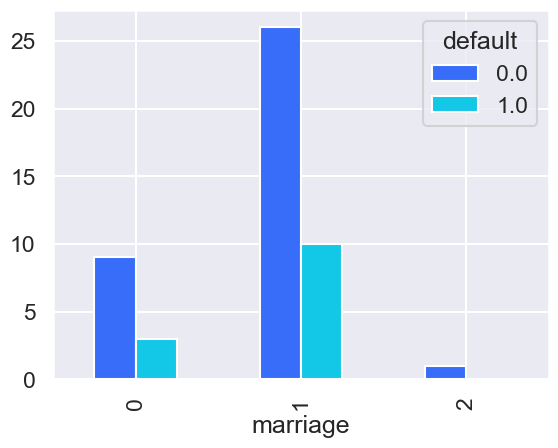

In [47]:
pd.crosstab(df_norm.marriage, df_norm.default).plot(kind='bar')

<AxesSubplot: xlabel='age_by_bin'>

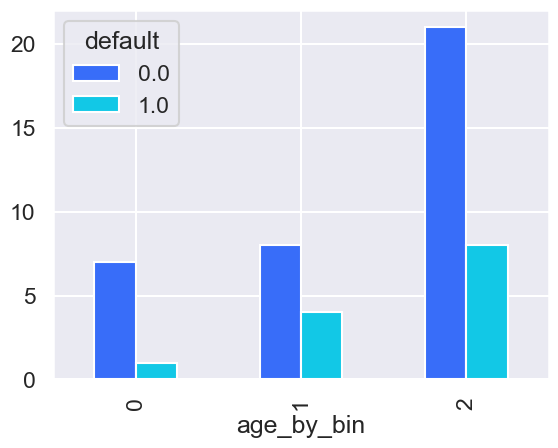

In [48]:
pd.crosstab(df_norm.age_by_bin, df_norm.default).plot(kind='bar')

<AxesSubplot: xlabel='sex'>

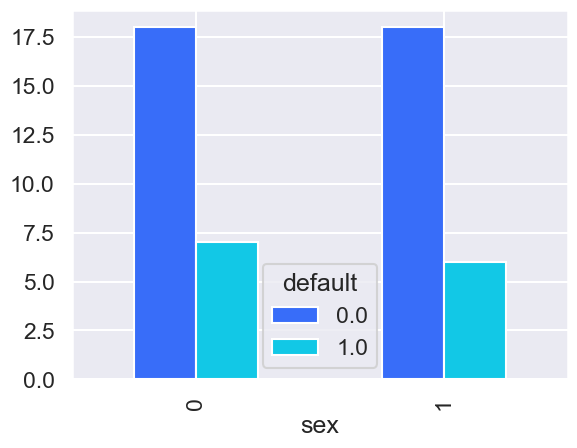

In [49]:
pd.crosstab(df_norm.sex, df_norm.default).plot(kind='bar')

<AxesSubplot: xlabel='education'>

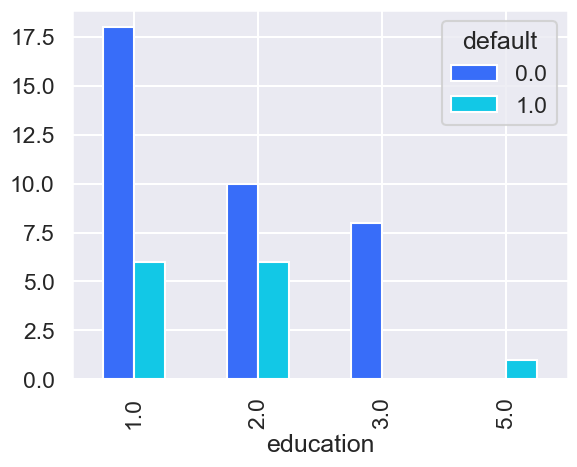

In [50]:
pd.crosstab(df_norm.education, df_norm.default).plot(kind='bar')

<AxesSubplot: xlabel='pay_1'>

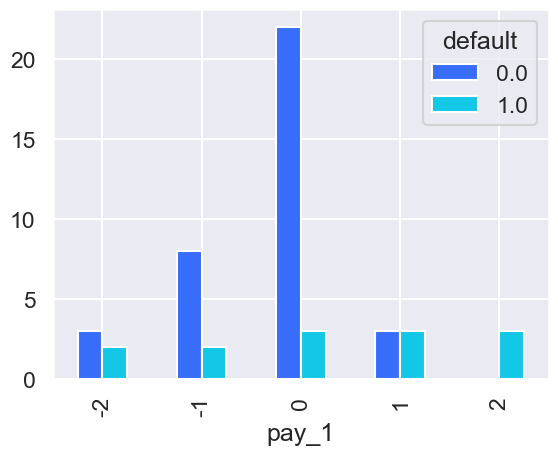

In [51]:
pd.crosstab(df_norm.pay_1, df_norm.default).plot(kind='bar')

<AxesSubplot: xlabel='pay_1'>

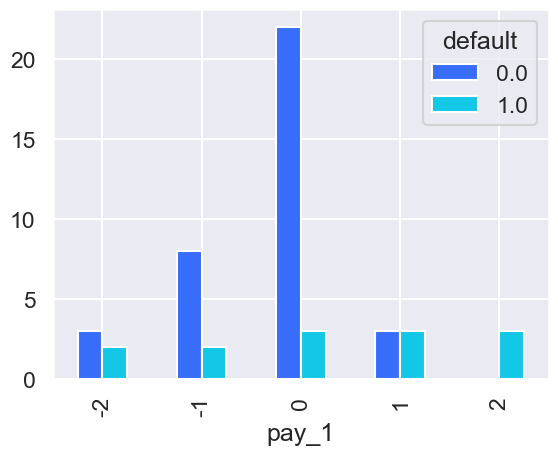

In [52]:
pd.crosstab(df_norm.pay_1, df_norm.default).plot(kind='bar')

<AxesSubplot: xlabel='pay_2'>

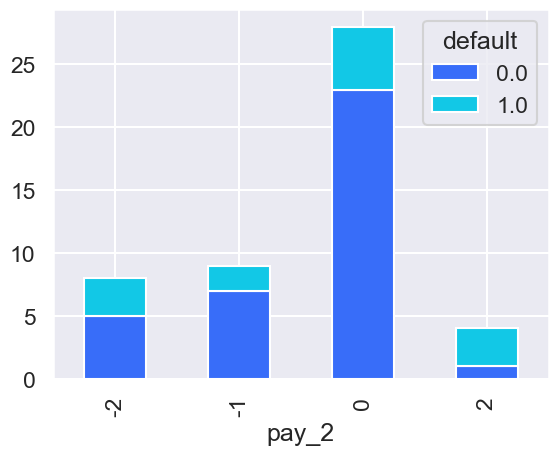

In [53]:
pd.crosstab(df_norm.pay_2, df_norm.default).plot(kind='bar', stacked=True)

# Parte 8 - Plan de Accion

Se nos plantea el desafio de aumntar las ganancias. En el caso de Riesgo de Default en Credito, el desafio de aumntar las ganancias es:

1. Identificar clientes actuales que son buenos pagadores, y aumentar sus lineas de credito en un monto X que mantenga su probabilidad de caer en default.

In [54]:
def print_accuracy(f, X_test, y_test):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == y_test)/len(y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars


In [58]:
X = df_norm[[c for c in df_norm.columns if c != "default"]]
y = df_norm['default']

# Partition data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}\n")
print(f"Test features shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")
display(X_train.head())

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print_accuracy(model.predict, X_test, y_test)

Training features shape: (39, 23)
Training target shape: (39,)

Test features shape: (10, 23)
Test target shape: (10,)


,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,education,limit_bal,marriage,pay_1,...,pay_5,pay_6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,sex,age_by_bin
ID,,,,,,,,,,,,,,,,,,,,,
32,30518.000,29618.000,22102.000,22734.000,23217.000,23680.000,2.000,50000.000,1,2,...,0,0,1718.000,1500.000,1000.000,1000.000,1000.000,716.000,1,2
39,0.000,780.000,0.000,0.000,0.000,0.000,1.000,50000.000,1,1,...,-2,-2,780.000,0.000,0.000,0.000,0.000,0.000,1,1
22,316.000,316.000,316.000,0.000,632.000,316.000,2.000,120000.000,0,-1,...,-1,-1,316.000,316.000,0.000,632.000,316.000,0.000,0,2
36,30265.000,-131.000,-527.000,-923.000,-1488.000,-1884.000,1.000,160000.000,1,-1,...,-2,-1,131.000,396.000,396.000,565.000,792.000,0.000,1,2
20,0.000,0.000,0.000,0.000,0.000,0.000,1.000,180000.000,1,1,...,-2,-2,0.000,0.000,0.000,0.000,0.000,0.000,0,2


Accuracy = 100.0%


In [57]:
f = lambda x: model.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test)

ValueError: cannot reshape array of size 23 into shape (1,22)